### Single-GPU benchmarks of different multiple RHS (mRHS) matrix-vector multiplication kernels
The setup is a set of lattices (a matrix field and several vector fields) on a 4D Grid (here `8.8.8.8`).
The matrices have `N x N` shape, the vectors subsequently are of size `N`.
We test the values `N = 32, 64, 128`.
The number of right hand sizes is given by `numRHS = 1, 12, 24, 36, 48, 60`. 
Each kernel is run 100 times and the average of the faster 50% of the runs is shown.
The results are shown with 3 different normalizations:   
- `1` (None)  
- `numRHS*N**2` (flops-normalized)  
- `N**2 + 2*N*numRHS` (bandwidth-normalized)  

### Kernels
5 different kernels are being tested.

#### matmul_blas
This kernel uses the cuBLAS library.
Since there is no native mRHS matrix-vector call, we use the `gemmStridedBatched` routine.
This routine performs matrix-matrix mul on a batch of matrices and assumes a fixed stride between memory locations of the matrices, hence `Strided`. 
To this end, the set of vector fields are transform to a single matrix field (see plots: `cp-in`, orange).
Additionally, the matrices must be contiguous in memory, so a Grid-style memory layout requires extra transformation work.
After the transformation the cuBLAS kernel can be called (see plots: `op`, green).
Finally, the resulting matrix field must be transformed back into a set of vector field (see plots: `cp-out`, red).

#### matmul_shmem
This kernel makes extensive use of the shared memory of the GPU.
It also performs standard batched matrix-matrix multiplication, but does the transformation from vectorfields to matrixfield directly when loading the data into the shared memory (see plots: `op`, green).
Since the implementation is a bit naive, it cannot be compiled for `N=128` since the shared memory of the GPUs is not large enough.
This could in principle be easily fixed by tiling the matrix-matrix multiplication.
When writing the results out, the kernel also performs the necessary transformation on the go.

#### matmul_lanes
This kernel uses the Grid-style memory layout natively.
SIMT-lanes are mapped to warps (32 'threads').
Again, no copy operation is needed, as the kernel performs this operation itself. 
Since the lanes are so large, cache reuse is low.
This is the reason, that this kernel performs consistenly worse than the other options (see plots: `op`, green).

#### stencil_blas
This kernel is very similar to matmul_blas, with a few exceptions.
Instead of performing on-site matmul, it performs matmul with a matrix from a neighbor site (here, the x-direction).
Hence, a fixed stride between matrices is not given anymore and we can not use the `gemmStridedBatched` routine.
Instead, the `gemmBatched` call is used, which additionally accepts a memory mapping. 
This mapping maps the memory location of the left matrix to the location of the right matrix for each pair of matrices in the batch.
Therefore, some setup is required to prepare this map (see plot: `malloc`, yellow)

#### stencil_lanes
This kernel is very similar to matmul_lanes, except that it performs matmul with a matrix on a neighbor site (here x-direction). 
This kernel suffers the same illness as matmul_lanes and therefore performs badly (see plot: `op`, green).

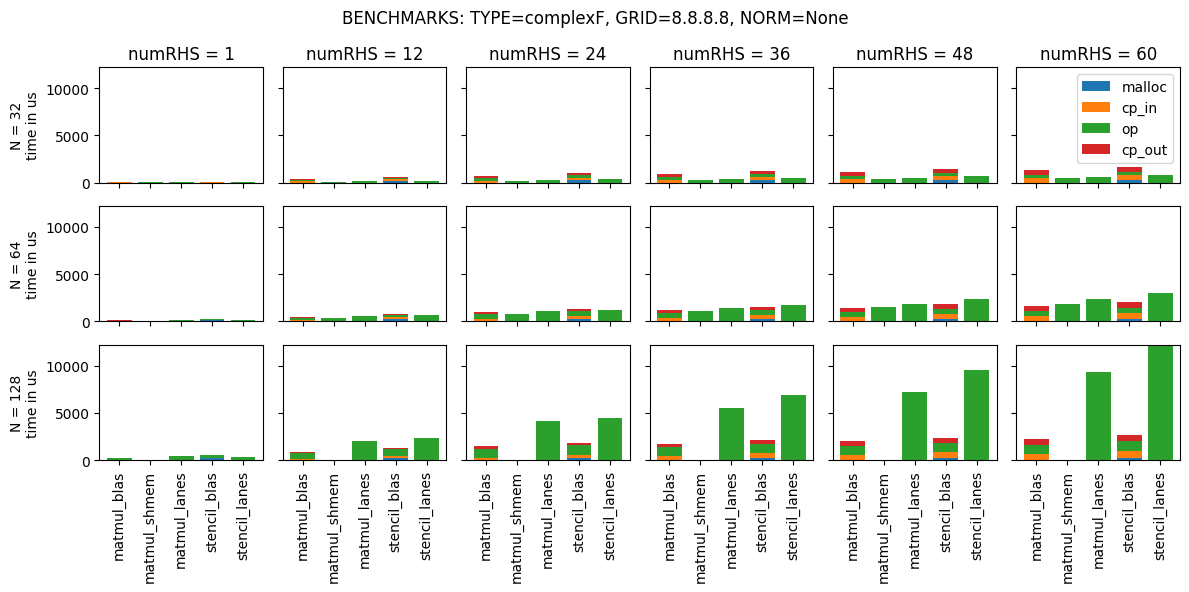

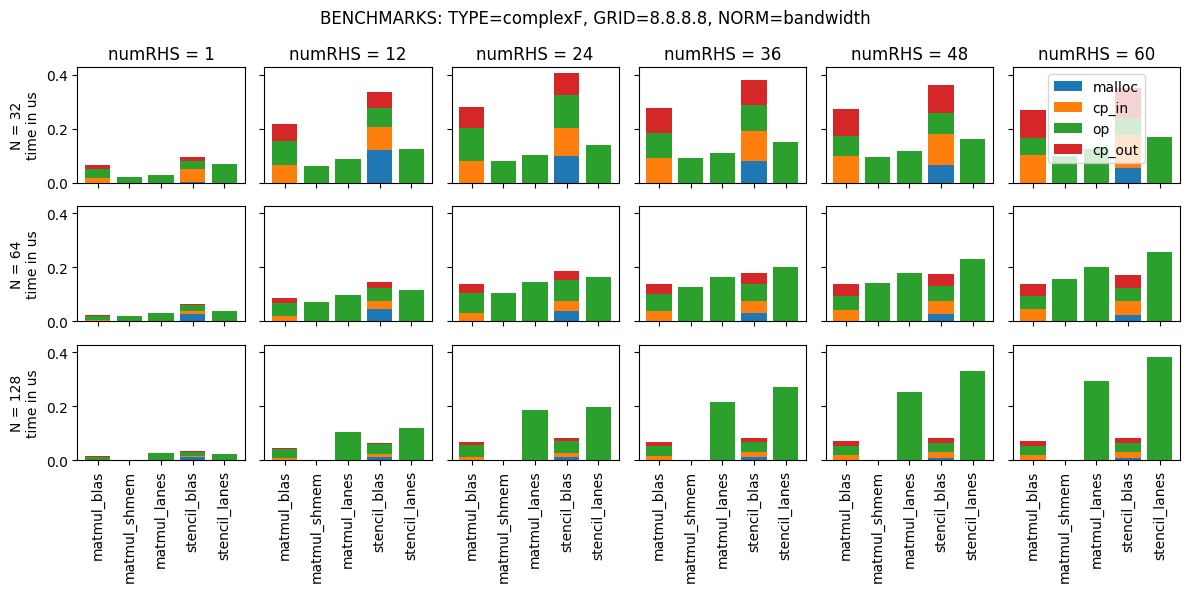

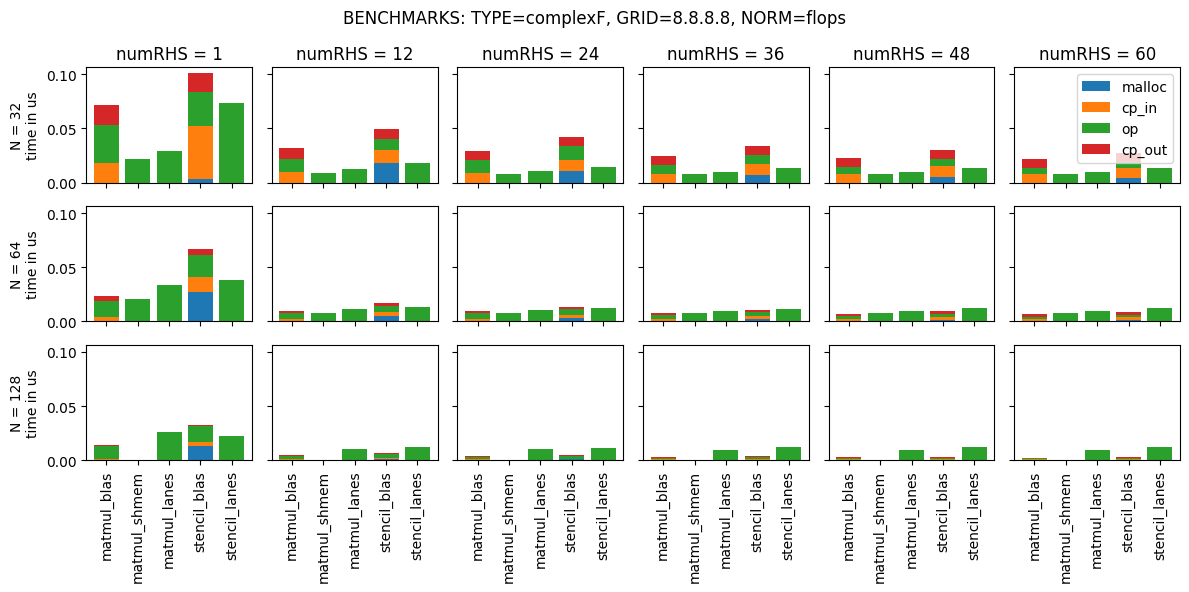

In [1]:
import os
os.chdir("/home/tobias/phd/cuda_grid/runs")
import pyBench as pyBench

data = pyBench.load()
plotter = pyBench.Plotter(data)
plotter.reduce()
plotter.plot_fixed_grid(grid='8.8.8.8')
plotter.plot_fixed_grid(grid='8.8.8.8', normalization="bandwidth")
plotter.plot_fixed_grid(grid='8.8.8.8', normalization="flops")